In [1]:
import numpy as np

from colorconv import ConvexCluster

from numcompress import compress

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.interpolate import interp1d

import pandas as pd
import statsmodels.api as sm

In [2]:
def non_dominated_front(points_x, points_y):
    """
    Returns the non-dominated (Pareto) front of a list of 2-D points using Kung's algorithm.
    
    Args:
    - points_x: List or array containing the x-coordinates of points.
    - points_y: List or array containing the y-coordinates of points.
    
    Returns:
    - List of indices representing the points on the Pareto front.
    """
    assert len(points_x) == len(points_y), "Number of x and y points must be the same"
    
    n = len(points_x)
    pareto_front = []
    dominated = [False] * n
    
    for i in range(n):
        for j in range(n):
            if i != j:
                if points_x[i] <= points_x[j] and points_y[i] <= points_y[j]:
                    if points_x[i] < points_x[j] or points_y[i] < points_y[j]:
                        dominated[j] = True
    
    for i in range(n):
        if not dominated[i]:
            pareto_front.append(i)
    
    return pareto_front

In [3]:
def safelog(vals):
    with np.errstate(divide='ignore'):
        return np.log(vals)

In [4]:
def compression(grid):
    return len(compress(grid.flatten().tolist()))

In [5]:
def cost(grid):
    # get all unique values in the grid
    C = np.unique(grid)
    # get list of all coordinates of each cell in the grid
    M = np.argwhere(grid)
    # p_m equals to 1 divided by the number of cells in the grid
    p_m = 1 / len(M)

    cost_ = 0

    for c in C:
        for m in M:
            cost_ += np.exp( - (p_m * np.linalg.norm(m - np.argwhere(grid == c))**2))
    return cost_

def informativeness(grid):
    return np.log(2 ** (-cost(grid)))

In [6]:
X = np.zeros((4, 20))
d = 1
N = 10
s = 1
c = 0.05

cc = ConvexCluster(X, d, N, s, c)
l_m = cc.run()

In [7]:
l_m

array([[5., 5., 5., 9., 9., 9., 1., 1., 1., 1., 0., 0., 0., 0., 0., 4.,
        4., 4., 3., 3.],
       [5., 5., 9., 9., 9., 9., 1., 1., 1., 2., 0., 0., 0., 0., 4., 4.,
        4., 4., 3., 6.],
       [7., 9., 9., 9., 9., 9., 2., 2., 2., 2., 0., 0., 4., 4., 4., 4.,
        4., 6., 6., 6.],
       [7., 7., 9., 9., 9., 9., 8., 8., 8., 2., 2., 4., 4., 4., 4., 4.,
        4., 4., 6., 6.]])

In [8]:
informativeness(l_m)

-87.74460118496532

In [9]:
cc.degree_of_convexity()

0.9796682718031032

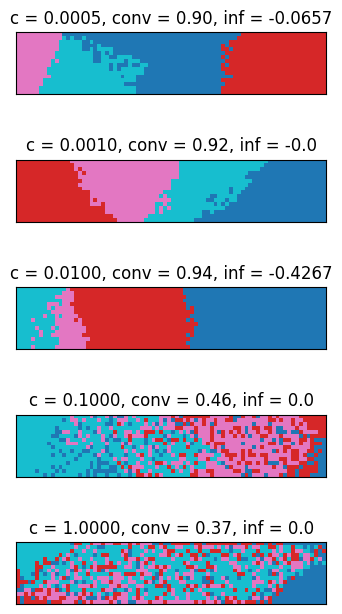

In [10]:
# just change convexity in the range 0.05 - 1
conn_values = [0.0005, 0.001, 0.01, 0.1, 1]

fig, ax = plt.subplots(5, 1, figsize=(4, 8))

for j, conn in enumerate(conn_values):
    a = ConvexCluster(X = np.zeros((16, 80)), 
                        d = 8, 
                        N = 4, 
                        s = 0.5, 
                        c = conn)
    labels = a.run()
    ax[j].imshow(labels, cmap='tab10', interpolation='none')
    ax[j].set_xticks([])
    ax[j].set_yticks([])
    ax[j].set_title(f'c = {conn:.4f}, conv = {a.degree_of_convexity():.2f}, inf = {informativeness(labels).round(4)}')

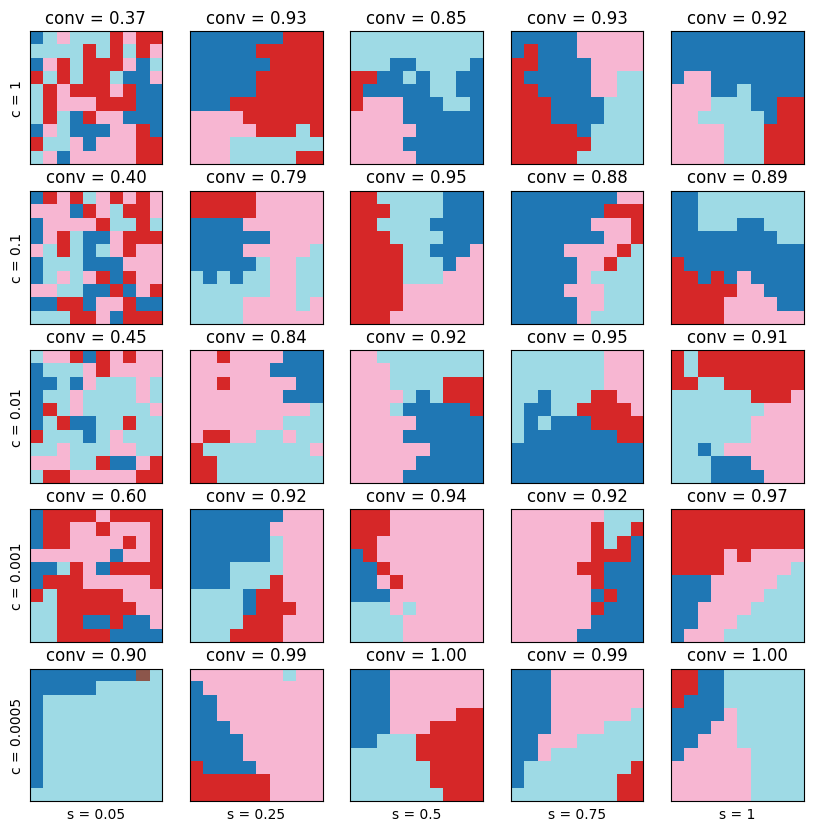

<Figure size 640x480 with 0 Axes>

In [11]:
# plot 4 x 4 possible color clusters with parameter smooth in [0.1, 0.25, 0.5, 1] and conn in [0.1, 0.25, 0.5, 1]
fig, ax = plt.subplots(5, 5, figsize=(10, 10))

smooth_values = [0.05, 0.25, 0.5, 0.75, 1]
conn_values = [0.0005, 0.001, 0.01, 0.1, 1]
conn_values = [_ for _ in reversed(conn_values)]

for i, smooth in enumerate(smooth_values):
    for j, conn in enumerate(conn_values):
        a = ConvexCluster(X = np.zeros((10, 10)), 
                         d = 2, 
                         N = 4, 
                         s = smooth, 
                         c = conn)
        labels = a.run()
        ax[i, j].imshow(labels, 
                        cmap='tab20', 
                        interpolation='none')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].set_title(f'conv = {a.degree_of_convexity():.2f}')
        # ax[i, j].set_title(f'MDL = {mdl(labels):.2f}')
        
# Label the conn values on the y-axis
for i, conn in enumerate(conn_values):
    ax[i, 0].set_ylabel('c = ' + str(conn))

# Label the smooth values on the x-axis
for j, smooth in enumerate(smooth_values):
    ax[4, j].set_xlabel('s = ' + str(smooth))

plt.show()
plt.tight_layout()

/var/folders/1c/pphtjl397rnbdcp94xmwzkqr0000gn/T/ipykernel_65208/3331231264.py:17: RuntimeWarning: divide by zero encountered in log
  return np.log(2 ** (-cost(grid)))


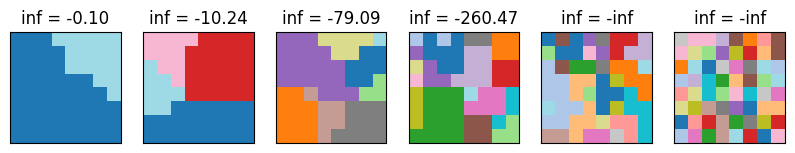

In [12]:
# fix c at 0.005 and s at s at 0.9, and draw clusters with N in [2, 4, 8, 16], compare the informativeness
fig, ax = plt.subplots(1, 6, figsize=(10, 4))

N_values = [2, 4, 8, 16, 32, 64]

for j, N in enumerate(N_values):
    a = ConvexCluster(X = np.zeros((8, 8)), 
                     d = 2, 
                     N = N, 
                     s = 1, 
                     c = 0.05)
    labels = a.run()
    ax[j].imshow(labels, 
                cmap='tab20', 
                interpolation='none')
    ax[j].set_xticks([])
    ax[j].set_yticks([])
    ax[j].set_title(f'inf = {informativeness(labels):.2f}')

    # ax[j].set_title(f'MDL = {mdl(labels):.2f}')

In [36]:
# generate 100 grids with random values of s and c, and N=4, d=2, X=30x30
def generate_grid(n, n_low, n_high, d = 2, X = 10, Y = 10):
    s_values = np.random.uniform(0, 1, n)
    c_values = np.random.uniform(0, 1, n)

    mdl_values = []
    conv_values = []
    cost_values = []
    categ = []

    for s, c in zip(s_values, c_values):
        N = np.round(np.random.uniform(n_low, n_high), 0).astype(int)
        a = ConvexCluster(X = np.zeros((X, Y)), 
                        d = d, 
                        N = N,
                        s = s, 
                        c = c)
        labels = a.run()
        mdl_values.append(compression(labels))
        conv_values.append(a.degree_of_convexity())
        cost_values.append(informativeness(labels))
        categ.append(N)
    
    return mdl_values, conv_values, cost_values, categ

In [37]:
mdl_values, conv_values, cost_values, categ = generate_grid(n = 50000, 
                                                            d = 2, 
                                                            X = 4,
                                                            Y = 20,
                                                            n_low = 2,
                                                            n_high = 11)

In [38]:
pareto_front_indices = non_dominated_front(mdl_values, cost_values)
pareto_front_points = [(mdl_values[i], cost_values[i]) for i in pareto_front_indices]

# find duplicates in either x or y and remove them
pareto_front_points = list(set(pareto_front_points))

x_pareto, y_pareto = zip(*pareto_front_points)

In [72]:
# create a smooth line over x_pareto and y_pareto using lowess
lowess = sm.nonparametric.lowess
smoothed = lowess(y_pareto, x_pareto, frac=0.7)

In [73]:
f = interp1d(x_pareto, y_pareto, 
             fill_value="extrapolate")

x = np.linspace(min(mdl_values), 
                max(mdl_values),  
                100)
y = f(x)

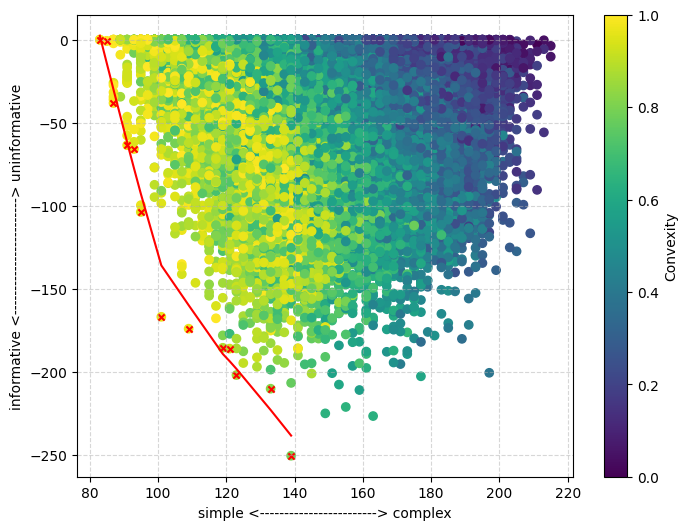

In [74]:
plt.figure(figsize=(8, 6))
plt.scatter(mdl_values, cost_values, c=conv_values, cmap='viridis', alpha=1)
# plt.plot(x, y, 'r--', linewidth=1)
plt.plot(smoothed[:, 0], smoothed[:, 1], 'r')
# plot pareto front in red
plt.scatter(*zip(*pareto_front_points), 
            c='red', 
            marker='x',
            s=20)
plt.grid(linestyle='--', alpha=0.5)
plt.xlabel('simple <------------------------> complex')
plt.ylabel('informative <------------------------> uninformative')
plt.colorbar(label='Convexity')
# plt.yscale('log')
plt.show()

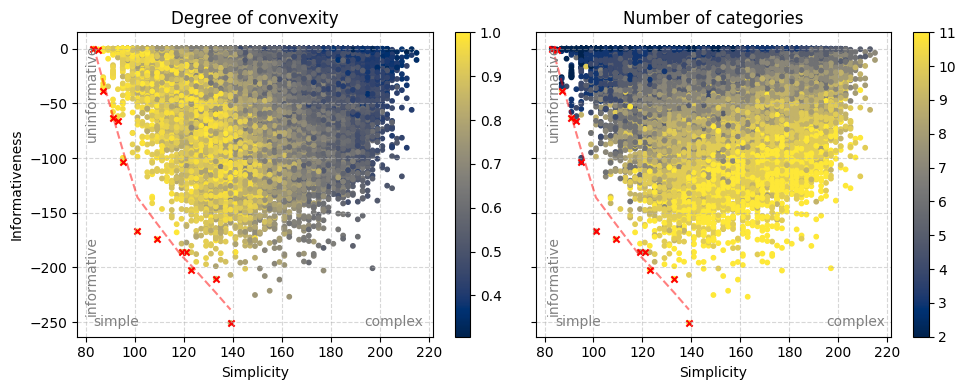

In [140]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), 
                               sharey=True)

# Plot with convexity
scatter1 = ax1.scatter(mdl_values, cost_values, 
                       c=conv_values, cmap='cividis', alpha=1,
                       s = 10, marker = 'o')
# ax1.plot(x, y, 'r--', linewidth=1)
ax1.plot(smoothed[:, 0], smoothed[:, 1], 'r--', alpha=0.5)
ax1.grid(linestyle='--', alpha=0.5)
ax1.scatter(*zip(*pareto_front_points), c='red', marker='x', s=20)
ax1.text(-1.25, 0.2, 'informative', ha='center',
         va='center', transform=ax2.transAxes,
         color = 'grey', rotation = 90)
ax1.text(-1.25, 0.8, 'uninformative', ha='center',
         va='center', transform=ax2.transAxes,
         color = 'grey', rotation = 90)
ax1.text(-1.18, 0.05, 'simple', ha='center', 
         va='center', transform=ax2.transAxes,
         color = 'grey')
ax1.text(-0.4, 0.05, 'complex', ha='center', 
         va='center', transform=ax2.transAxes,
         color = 'grey')
ax1.set_xlabel('Simplicity')
ax1.set_ylabel('Informativeness')
ax1.set_title('Degree of convexity')
# ax1.set_yscale('log')
cbar1 = fig.colorbar(scatter1, ax=ax1)

# Plot with number of categories
scatter2 = ax2.scatter(mdl_values, cost_values, c=categ, cmap='cividis', alpha=1,
                       s = 10, marker = 'o')
# ax2.plot(x, y, 'r--', linewidth=1)
ax2.plot(smoothed[:, 0], smoothed[:, 1], 'r--', alpha=0.5)
ax2.grid(linestyle='--', alpha=0.5)
ax2.scatter(*zip(*pareto_front_points), c='red', marker='x', s=20)
# ax2.set_xlabel('simple <------------------------> complex')
# add text in the top and bottom left corner
ax2.text(0.05, 0.2, 'informative', ha='center',
         va='center', transform=ax2.transAxes,
         color = 'grey', rotation = 90)
ax2.text(0.05, 0.8, 'uninformative', ha='center',
         va='center', transform=ax2.transAxes,
         color = 'grey', rotation = 90)
ax2.text(0.12, 0.05, 'simple', ha='center', 
         va='center', transform=ax2.transAxes,
         color = 'grey')
ax2.text(0.9, 0.05, 'complex', ha='center', 
         va='center', transform=ax2.transAxes,
         color = 'grey')
ax2.set_xlabel('Simplicity')
ax2.set_title('Number of categories')
# ax2.set_yscale('log')
cbar2 = fig.colorbar(scatter2, ax=ax2)

plt.tight_layout()
plt.show()

In [78]:
# for each point in (mdl_values, cost_values), calculate the distance to the points in the pareto front
distances = []

x_pareto = np.array(x_pareto)
y_pareto = np.array(y_pareto)

for i, j in zip(mdl_values, cost_values):
    distances.append(np.min(np.sqrt((i - x_pareto)**2 + (j - y_pareto)**2)))

In [79]:
df = pd.DataFrame({'convexity': conv_values,
                   'categories': categ,
                   'distance': distances})

In [80]:
# standardize categories and convexity
df['categories'] = (df['categories'] - df['categories'].mean()) / df['categories'].std()
df['convexity'] = (df['convexity'] - df['convexity'].mean()) / df['convexity'].std()

In [81]:
# statsmodels regression predicting distance from convexity and number of categories

X = df[['convexity', 'categories']]
y = df['distance']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

In [82]:
# summarize our model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                 1.254e+05
Date:                Wed, 14 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:33:47   Log-Likelihood:            -1.8403e+05
No. Observations:               50000   AIC:                         3.681e+05
Df Residuals:                   49997   BIC:                         3.681e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.7776      0.043   1462.391      0.000      62.694      62.862
convexity    -21.2079      0.043   -488.379      0.000     -21.293     -21.123
categories     7.9410      0.043    182.867      0.000       7.856       8.026
==============================================================================
Omnibus:                     1883.361   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2206.744
Skew:                          -0.452   Prob(JB):                         0.00
Kurtosis:                       3.491   Cond. No.                         1.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

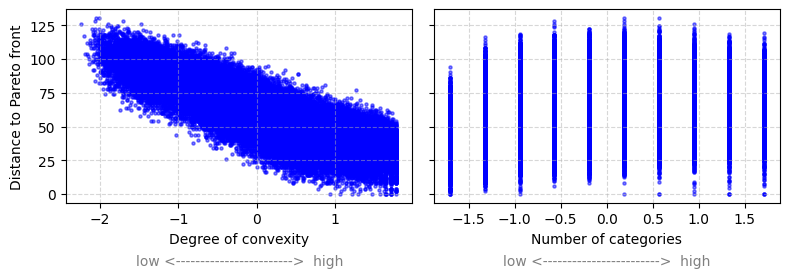

In [87]:
# plot convexity vs distance and categories vs distance in one plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

# Plot convexity vs distance
ax1.scatter(df['convexity'], df['distance'], alpha=0.5, color='b', s=5)
ax1.grid(linestyle='--', alpha=0.5)
ax1.set_xlabel('Degree of convexity')
ax1.set_ylabel('Distance to Pareto front')
ax1.text(-0.56, -0.3, 'low <------------------------>  high', ha='center', va='center', fontsize
            =10, transform=ax2.transAxes, color = 'grey')

# Plot categories vs distance
ax2.scatter(df['categories'], df['distance'], alpha=0.5, color='b', s=5)
ax2.grid(linestyle='--', alpha=0.5)
ax2.set_xlabel('Number of categories')
# add subscript (low <---> high) below the x-axis
ax2.text(0.5, -0.3, 'low <------------------------>  high', ha='center', va='center', fontsize
            =10, transform=ax2.transAxes, color = 'grey')
        

plt.tight_layout()
plt.show()